In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import ResNet50
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam

import pandas as pd
from tensorflow.keras.preprocessing import image

from sklearn.metrics import classification_report

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import typing_extensions
from collections import Counter
import numpy as np

from tensorflow.keras.mixed_precision import set_global_policy

set_global_policy('mixed_float16') 

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [3]:
IMG_SIZE = (32, 32)
BATCH_SIZE = 256
DATA_DIR = "D:/Pet projects/ML-Hackathon-IIT-BBSR/data/CIFAKE"
MODEL_SAVE_PATH = "D:/Pet projects/ML-Hackathon-IIT-BBSR/models"
EPOCHS = 50

In [4]:
train_ds = image_dataset_from_directory(
    os.path.join(DATA_DIR, "train"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

val_ds = image_dataset_from_directory(
    os.path.join(DATA_DIR, "test"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

class_names = train_ds.class_names
print("Classes:", class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Classes: ['FAKE', 'REAL']


In [ ]:
def get_class_distribution(dataset):
    labels = []
    for _, batch_labels in dataset:
        labels.extend(batch_labels.numpy().flatten().astype(int))  
    return Counter(labels)

train_class_dist = get_class_distribution(train_ds)
val_class_dist = get_class_distribution(val_ds)

print("Train Set Class Distribution:")
for cls, count in train_class_dist.items():
    print(f"{class_names[cls]}: {count}")

print("\nValidation Set Class Distribution:")
for cls, count in val_class_dist.items():
    print(f"{class_names[cls]}: {count}")



Train Set Class Distribution:
REAL: 50000
FAKE: 50000

Validation Set Class Distribution:
REAL: 10000
FAKE: 10000


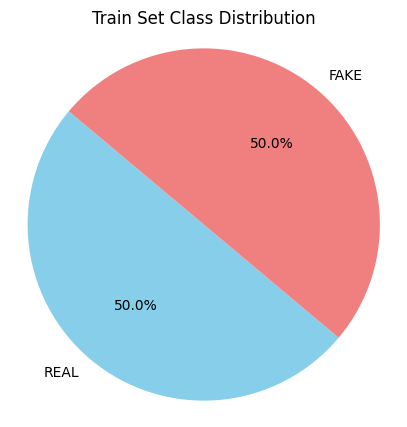

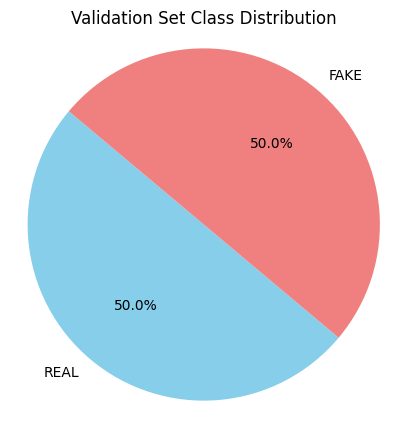

In [ ]:
def plot_class_distribution(counter, title):
    labels = ['REAL', 'FAKE']
    sizes = [counter[1], counter[0]]  # assuming 1=REAL, 0=FAKE
    colors = ['skyblue', 'lightcoral']
    
    plt.figure(figsize=(5, 5))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.axis('equal')
    plt.show()

plot_class_distribution(train_class_dist, 'Train Set Class Distribution')
plot_class_distribution(val_class_dist, 'Validation Set Class Distribution')


In [ ]:
def build_model(base_model):
    base_model.trainable = False 
    inputs = tf.keras.Input(shape=(32, 32, 3))
    x = base_model(inputs, training=False)  
    x = layers.GlobalAveragePooling2D()(x)  
    # Dense layers for classification
    x = layers.BatchNormalization()(x)  
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.4)(x)  
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x) 
    
    return models.Model(inputs, outputs)

resnet_base = ResNet50(include_top=False, weights='imagenet', input_shape=(32, 32, 3))
resnet_model = build_model(resnet_base)

In [ ]:
def compile_and_train(model, name, train_ds, val_ds, epochs=20, batch_size=128, model_save_path="models"):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    checkpoint_path = os.path.join(model_save_path, f"{name}_best.h5")
    model_checkpoint = ModelCheckpoint(
        checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop, model_checkpoint], 
        verbose=1
    )

    model.save(os.path.join(model_save_path, f"{name}.h5"))
    return history


history = compile_and_train(resnet_model, "ResNet50_CIFAKE", train_ds, val_ds, epochs=20, batch_size=128)


Epoch 1/20
391/391 [==============================] - ETA: 0s - loss: 0.9449 - accuracy: 0.8499 - precision_4: 0.8521 - recall_4: 0.8468
Epoch 1: val_loss improved from inf to 0.46524, saving model to models\ResNet50_CIFAKE_best.h5


d:\Pet projects\ML-Hackathon-IIT-BBSR\hackathon_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


391/391 [==============================] - 288s 724ms/step - loss: 0.9449 - accuracy: 0.8499 - precision_4: 0.8521 - recall_4: 0.8468 - val_loss: 0.4652 - val_accuracy: 0.8716 - val_precision_4: 0.8752 - val_recall_4: 0.8667
Epoch 2/20
391/391 [==============================] - ETA: 0s - loss: 0.4801 - accuracy: 0.8617 - precision_4: 0.8636 - recall_4: 0.8592
Epoch 2: val_loss improved from 0.46524 to 0.43979, saving model to models\ResNet50_CIFAKE_best.h5
391/391 [==============================] - 274s 700ms/step - loss: 0.4801 - accuracy: 0.8617 - precision_4: 0.8636 - recall_4: 0.8592 - val_loss: 0.4398 - val_accuracy: 0.8724 - val_precision_4: 0.8810 - val_recall_4: 0.8611
Epoch 3/20
391/391 [==============================] - ETA: 0s - loss: 0.4607 - accuracy: 0.8628 - precision_4: 0.8649 - recall_4: 0.8599
Epoch 3: val_loss did not improve from 0.43979
391/391 [==============================] - 263s 670ms/step - loss: 0.4607 - accuracy: 0.8628 - precision_4: 0.8649 - recall_4: 0.8

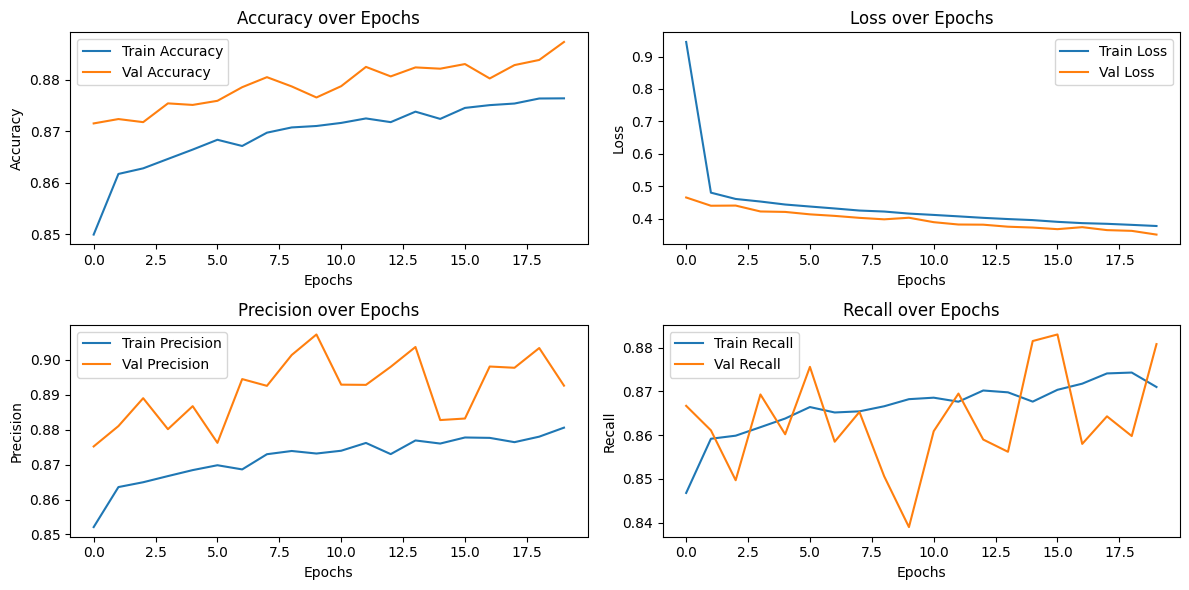

In [ ]:
def plot_history(history):
    plt.figure(figsize=(12, 6))

    # Accuracy plot
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Precision plot
    plt.subplot(2, 2, 3)
    plt.plot(history.history['precision_4'], label='Train Precision')
    plt.plot(history.history['val_precision_4'], label='Val Precision')
    plt.title('Precision over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    # Recall plot
    plt.subplot(2, 2, 4)
    plt.plot(history.history['recall_4'], label='Train Recall')
    plt.plot(history.history['val_recall_4'], label='Val Recall')
    plt.title('Recall over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    plt.tight_layout() 
    plt.show()

plot_history(history)

In [ ]:
def build_model_hp(hp):
    resnet_base = ResNet50(include_top=False, weights='imagenet', input_shape=(32, 32, 3))
    resnet_base.trainable = False  
    inputs = tf.keras.Input(shape=(32, 32, 3))
    x = resnet_base(inputs, training=False)  

    x = layers.GlobalAveragePooling2D()(x)  
    x = layers.BatchNormalization()(x) 
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.05)
    x = layers.Dropout(dropout_rate)(x) 
    x = layers.Dense(64, activation='relu')(x) 
    outputs = layers.Dense(1, activation='sigmoid')(x)  

    model = models.Model(inputs, outputs)

    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG', default=1e-3)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    return model

def tune_model(train_ds, val_ds, search_type='RandomSearch'):
    if search_type == 'RandomSearch':
        tuner = kt.RandomSearch(
            build_model_hp, 
            objective='val_loss', 
            max_trials=1,
            executions_per_trial=1,  
            directory='kt_tuner', 
            project_name='cifake_tuning_random',
            overwrite=False 
        )
    elif search_type == 'Hyperband':
        tuner = kt.Hyperband(
            build_model_hp, 
            objective='val_loss', 
            max_epochs=5,  
            hyperband_iterations=1,
            directory='kt_tuner', 
            project_name='cifake_tuning_hyperband',
            overwrite=False
        )

    checkpoint_path = f'models/best_model_checkpoint_{search_type}.h5'
    model_checkpoint = ModelCheckpoint(checkpoint_path, 
                                       monitor='val_loss', 
                                       save_best_only=True, 
                                       verbose=1)
    
    tuner.search(train_ds, validation_data=val_ds, epochs=5, batch_size=128, callbacks=[model_checkpoint])

    best_model = tuner.get_best_models(num_models=1)[0]
    
    return best_model, tuner


In [12]:
best_model, tuner = tune_model(train_ds, val_ds, search_type='RandomSearch')

Trial 1 Complete [01h 41m 03s]
val_loss: 0.3211263120174408

Best val_loss So Far: 0.3211263120174408
Total elapsed time: 01h 41m 03s


In [ ]:
# best_model, tuner = tune_model(train_ds, val_ds, search_type='Hyperband')

In [ ]:
IMG_SIZE = (32, 32)

def load_test_images(folder_path):
    image_paths = [os.path.join(folder_path, fname) for fname in os.listdir(folder_path) if fname.endswith('.png')]
    image_paths.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))  # Sort by filename like 1.png, 2.png...
    images = []

    for path in image_paths:
        img = image.load_img(path, target_size=IMG_SIZE)
        img_array = image.img_to_array(img)
        img_array /= 255.0 
        images.append(img_array)

    return np.array(images), image_paths

def save_predictions_to_csv(paths, predictions, filename):
    image_names = [os.path.basename(path) for path in paths]
    predictions_df = pd.DataFrame({
        'Image name': image_names,
        'Prediction': ['Real' if pred == 1 else 'Fake' for pred in predictions.flatten()]
    })
    predictions_df.to_csv(filename, index=False)
    print(f"Predictions saved to: {filename}")

# Load and predict on Test_dataset_1
test_ds_1_images, test_ds_1_paths = load_test_images("D:/Pet projects/ML-Hackathon-IIT-BBSR/Test datasets/Test datasets/Test_dataset_1")
y_pred_1 = (best_model.predict(test_ds_1_images) > 0.5).astype(int)
save_predictions_to_csv(test_ds_1_paths, y_pred_1, 'Test_1_results.csv')

# Load and predict on Test_dataset_2
test_ds_2_images, test_ds_2_paths = load_test_images("D:/Pet projects/ML-Hackathon-IIT-BBSR/Test datasets/Test datasets/Test_dataset_2")
y_pred_2 = (best_model.predict(test_ds_2_images) > 0.5).astype(int)
save_predictions_to_csv(test_ds_2_paths, y_pred_2, 'Test_2_results.csv')


1/1 [==============================] - 0s 299ms/step
Predictions saved to: Test_1_results.csv
1/1 [==============================] - 0s 300ms/step
Predictions saved to: Test_2_results.csv


1/1 [==============================] - 0s 300ms/step


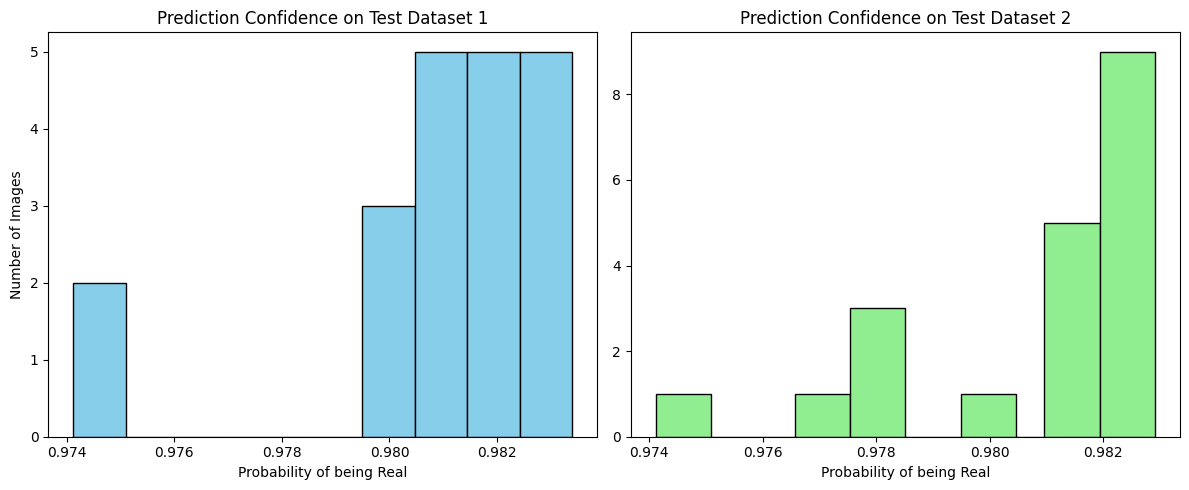

In [ ]:
# Get raw probabilities instead of 0/1
probs_1 = best_model.predict(test_ds_1_images).flatten()
probs_2 = best_model.predict(test_ds_2_images).flatten()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(probs_1, bins=10, color='skyblue', edgecolor='black')
plt.title("Prediction Confidence on Test Dataset 1")
plt.xlabel("Probability of being Real")
plt.ylabel("Number of Images")

plt.subplot(1, 2, 2)
plt.hist(probs_2, bins=10, color='lightgreen', edgecolor='black')
plt.title("Prediction Confidence on Test Dataset 2")
plt.xlabel("Probability of being Real")

plt.tight_layout()
plt.show()


In [ ]:
# Simulate dummy ground truth for testing (10 real + 10 fake)
dummy_labels_1 = np.array([1]*10 + [0]*10)  # 1: Real, 0: Fake
dummy_labels_2 = np.array([1]*10 + [0]*10)

print("Classification Report for Test Dataset 1 (Fake Labels)")
print(classification_report(dummy_labels_1, y_pred_1))

print("Classification Report for Test Dataset 2 (Fake Labels)")
print(classification_report(dummy_labels_2, y_pred_2))


Classification Report for Test Dataset 1 (Fake Labels)
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.50      1.00      0.67        10

    accuracy                           0.50        20
   macro avg       0.25      0.50      0.33        20
weighted avg       0.25      0.50      0.33        20

Classification Report for Test Dataset 2 (Fake Labels)
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.50      1.00      0.67        10

    accuracy                           0.50        20
   macro avg       0.25      0.50      0.33        20
weighted avg       0.25      0.50      0.33        20



d:\Pet projects\ML-Hackathon-IIT-BBSR\new_hackathon_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Pet projects\ML-Hackathon-IIT-BBSR\new_hackathon_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Pet projects\ML-Hackathon-IIT-BBSR\new_hackathon_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,